#### Requires: mdtraj, matplotlib, numpy (optional nglview)

In [2]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv

import pymdna as mdna 

joblib is not installed. Falling back to sequential computation.


To generate a 3D DNA structure we can use the `mdna` package and the `sequence_to_pdb()` function, which is as simple as running the code below:

In [3]:
traj = mdna.sequence_to_pdb(save=True)

Sequence: CGCGAATTCGCG
Number of base pairs: 12


/Users/thor/surfdrive/Education/knot_theory_honours/pymdna/utils.py:84: RuntimeWarning: invalid value encountered in divide
  omega_normalized = np.where(omega_norm != 0, omega / omega_norm, omega)


While save=True the code generates a pdb file called `my_dna.pdb`, which you can visualize in VMD or anyother software you prefer

In [4]:
# Optional - view the trajectory using nglview
view = nv.show_mdtraj(traj)
view

NGLWidget()

### Parametric functions in python

A parametric function in 3D can be defined by three functions, one for each dimension (x, y, z), depending on one or more parameters. Let's define a simple spiral parametric function depending on a single parameter `t`:

In [77]:
def parametric_spiral(t, radius=5):
    x = np.cos(t)*radius
    y = np.sin(t)*radius
    z = t  # Linear increment for simplicity
    return x, y, z

Now, generate a range of values for tt, which we will use to compute points on the curve:

In [78]:
t = np.linspace(0, 3 * np.pi, 100)  # 0 to 3π with 50 points

Use the parametric function to compute the x, y, and z coordinates of the curve:

In [79]:
x, y, z = parametric_spiral(t)

Finally, use Matplotlib to plot the 3D curve:

Text(0.5, 0.92, '3D Parametric Curve')

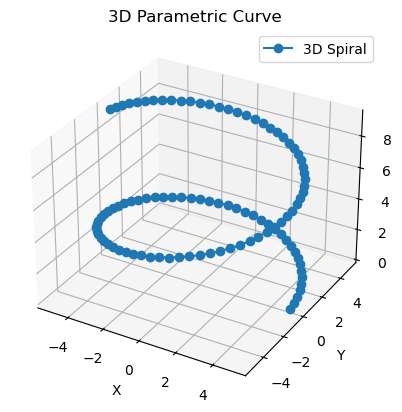

In [80]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, 'o-', label='3D Spiral')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Parametric Curve')

Finally we can use the the x,y,z coordinates to define control points to construct a spline. A spline is a mathematical function used for creating smooth curves. It's a type of piecewise polynomial function that is very versitale due to it's parametric nature.

In [81]:
control_points = np.array([x, y, z]).T  # Create a (n_points, 3) array
spline = mdna.SplineFrames(control_points)

We can now visualize the spline in 3D, notice that you also see a orthonormal basis at each point!

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


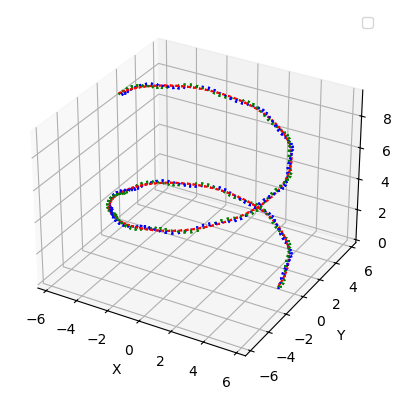

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

In [82]:

spline.plot_frames(equal=True)

 Convieniently we can subsequently use these reference frames to position and map our DNA base pairs.

In [83]:
# Now we generate the DNA structure, which creates a trajectory object
generator = mdna.StructureGenerator(spline)
traj = generator.traj
traj

ACTCATCCCATACCTCATCCCCTATCGAGAGTCGACCCGGCGTGATACATTTGGCAAGATGCCACTGCGGAAATACCTGACGCAAATTTACTGTGACATTCTAAGAATGGGGATGCGGTTGATAACTTTCGGAGTCTGCAAC


<mdtraj.Trajectory with 1 frames, 5822 atoms, 284 residues, without unitcells at 0x7f801916ff10>

Next, we can save the pdb structure for visualization:

In [84]:
traj.save('spiral_dna.pdb')

## Your turn

Finally we are going to generate a DNA structure that is shaped in the form of a knot of your choosing! To do so you need to define at least 4 control points, but you can add as many as you want. Control points need to be defined in as cartesian coordinates stored in a numpy array, like `control_points = np.array([[0,0,0],[0,1,0],[0,2,0],[0,3,0]])`, this will generate a linear sequence of DNA in the y-direction. Anything will do except a linearstrand. Or you can define your own parameteric function as shown above with the spiralled DNA example.

In [63]:
control_points  = # Replace this with the control points with shape (n_points, 3)

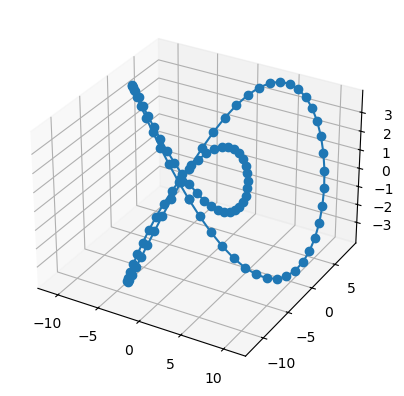

In [64]:
# plot the control points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*control_points.T, 'o-')

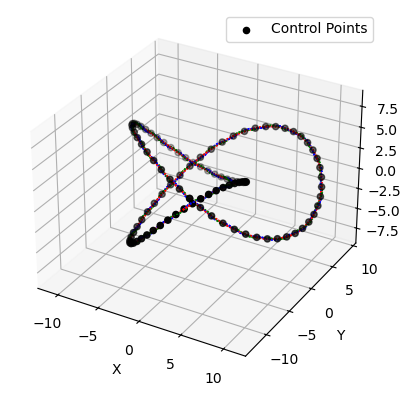

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

In [65]:
# generate the spline and plot it
spline = mdna.SplineFrames(control_points)
n_bp = spline.frames.shape[0]
print(f'Number of base pairs is {n_bp} that fit along the spline.')
spline.plot_frames(equal=True)

In [67]:
# Note that if the sequence is provided, the number of base pairs must match the number of frames
# Here a sequence can be provided, otherwise a random sequence will be generated
sequence = None # Make sure if you create your own sequenece, it has the same length as the number of base pairs n_bp 

# Here we generate the DNA structure, which creates a trajectory object
dna = mdna.StructureGenerator(spline,sequence=sequence)
custom_traj = dna.traj
custom_traj

GCAAACCGCCTATTCCCTACATGCAGACGCGCGTACTCCAGGAGCCGATGTATTGGAGTTGTAGATTCGAACTACATCACTACACGGTAAGTAGAGTCCCTGCCATTTAGAATGGTCTCTACCTGACCGGATGACCCCTTTAAGCCGTATGAATGAGGCCCACAGCAAACAATGACAACCGCATTACCGCGAGTATTCATCCCAGTAGCAGGTAGGGATTCACGCACTTCTCCGATCCTATCATTGTTGGTGCCGACTTTGGGGATAATCAGTACTAGCGACGAGGGTAATTCCTGATGACGGGCCGACTCGTGTGTGATACCTTCCTTCCGCCCTTGAA


<mdtraj.Trajectory with 1 frames, 13940 atoms, 680 residues, without unitcells at 0x189a05d90>

In [68]:
# visualize the DNA structure
view = nv.show_mdtraj(custom_traj)
view

NGLWidget()

In [62]:
# Save your custom DNA structure! 
custom_traj.save('your_custom_dna.pdb')